In [1]:
#### IMPORT ####
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import os, subprocess, sys, re

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


In [2]:
#### FILE INVENTORY ####
"""
- Note: 4 replicates per condition, demarcated as a-d in fastq prefix
"""

## DIRECTORIES
pwd = "/groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/"
data_dir = f"{pwd}FASTQS/"
key_file = pd.read_excel(f"CRISPResso_Key_for_OnTarget_Quantification.xlsx")
data_dir = "/groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/"

## DATA
all_fastqs = [f"{x}" for x in glob.glob(f"{data_dir}*/*fastq.gz", recursive=True)]
r1_suffix = "_L001_R1_001.fastq.gz"
r2_suffix = "_L001_R2_001.fastq.gz"

# CREATE REPLICATE SETS TO PARALLELIZATION
igeo_paper_samples = list(key_file.iloc[:96].Sample_Name.unique())
rep1s = [x for x in igeo_paper_samples if "a_" in x]
rep1_bases = [x.replace(r1_suffix, "") for x in all_fastqs if x.endswith(r1_suffix) and \
              x.split("/")[-1].split(r1_suffix)[0].split("_S")[0].replace("-", "_") in rep1s]
rep2s = [x for x in igeo_paper_samples if "b_" in x]
rep2_bases = [x.replace(r1_suffix, "") for x in all_fastqs if x.endswith(r1_suffix) and \
              x.split("/")[-1].split(r1_suffix)[0].split("_S")[0].replace("-", "_") in rep2s]
rep3s = [x for x in igeo_paper_samples if "c_" in x]
rep3_bases = [x.replace(r1_suffix, "") for x in all_fastqs if x.endswith(r1_suffix) and \
              x.split("/")[-1].split(r1_suffix)[0].split("_S")[0].replace("-", "_") in rep3s]
rep4s = [x for x in igeo_paper_samples if "d_" in x]
rep4_bases = [x.replace(r1_suffix, "") for x in all_fastqs if x.endswith(r1_suffix) and \
              x.split("/")[-1].split(r1_suffix)[0].split("_S")[0].replace("-", "_") in rep4s]
other_bases = [x.replace(r1_suffix, "") for x in all_fastqs if x.endswith(r1_suffix) and \
              x.split("/")[-1].split(r1_suffix)[0].split("_S")[0] not in rep1s+rep2s+rep3s+rep4s]
base_sets = {1:rep1_bases, 
             2:rep2_bases, 
             3:rep3_bases,
             4:rep4_bases, 
             5:other_bases}
all_sets = [rep1s, rep2s, rep3s, rep4s]

# Verify inventory correct
print(len(rep1s) == len(rep1_bases), 
      len(rep2s) == len(rep2_bases), 
      len(rep3s) == len(rep3_bases), 
      len(rep4s) == len(rep4_bases))

# MERGED
merge_dir = data_dir + "Merged/"
if not os.path.exists(merge_dir):
    os.makedirs(merge_dir)
    
# RESULTS
results_dir = f"{data_dir}Results/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

True True True True


In [3]:
#### RUN CRISPRESSO ####
"""
- SETUP CRISPResso2 for all samples
- For speed, create seperate jobs for each set of replicates
"""
n = 1
bash_scripts = []

## CREATE BASH SCRIPT FOR EACH SET
for set_x in all_sets:
    # COLLECT SET INFO
    set_df = key_file.loc[key_file.Sample_Name.isin(set_x)]
    set_bases = base_sets[n]
    
    # START BASH
    set_name = f"AmyKai_CRISPResso_Rep{n}"
    print(f"#### PROCESSING: {set_name}")
    bash_script = f"Run_{set_name}.sh"
    bash_lines = ["#!/bin/bash", "#SBATCH -p standard",
                  f"#SBATCH --job-name {n}_CRISPRESSO", "#SBATCH -o %j_%x.out", 
                  "#SBATCH -e %j%j_%x.err", "## ACTIVATE CONDA", 
                  'eval "$(conda shell.bash hook)"', "conda activate Test_Py_3_9"]
    
    for sample_base in set_bases:
        ## VARIABLES
        # Sample
        sample_id = sample_base.split("/")[-1].split("_S")[0]
        r1 = f"{sample_base}{r1_suffix}" #{data_dir}
        r2 = f"{sample_base}{r2_suffix}"
        #print(sample_id, r1, r2)
        temp_df = key_file.loc[key_file.Sample_Name == sample_id.replace("-", "_")]

        # Other Parameters
        guide = temp_df.gRNA_Sequence.values[0]
        amplicon = temp_df.Amplicon_Sequence.values[0]
        hdr_product = temp_df.HDR_Product.values[0]
        default_min_aln_score = 50

        # MERGE
        merged_file = f"{merge_dir}{sample_id}_merged.fastq.gz"

        if not os.path.exists(merged_file):
            fastp_cli = (f"fastp --in1 {r1} --in2 {r2} --detect_adapter_for_pe --merge --merged_out "
                         f"{merged_file} -h {merge_dir}{sample_id}_merged_fastp.html -j "
                         f"{merge_dir}{sample_id}_merged_fastp.json --overrepresentation_analysis -A " 
                         f"&> {merge_dir}{sample_id}_merged_fastp.log")
            print("###FASTP: ", fastp_cli)
            bash_lines.append(f"####FASTP on: {sample_id}")
            bash_lines.append(fastp_cli)

        # CRISPRESSO 
        if str(hdr_product) == "nan": # QUANT INDELS ONLY
            crispresso_cli = (f"/shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 " 
                              f"{merged_file} --amplicon_seq {amplicon} "
                              f"-g {guide} --default_min_aln_score {default_min_aln_score} " 
                              f"--file_prefix {sample_id.replace('-', '_')} --output_folder {results_dir}")
            print("####CRISPResso: ", crispresso_cli)
            bash_lines.append(f"####CRISPResso on: {sample_id}")
            bash_lines.append(crispresso_cli)
        else: # RUN IN HDR MODE
            crispresso_cli = (f"/shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 "
                              f"{merged_file} --amplicon_seq {amplicon} "
                              f"-g {guide} -e {hdr_product} --default_min_aln_score {default_min_aln_score} "
                              f"--file_prefix {sample_id.replace('-', '_')} --output_folder {results_dir}")
            print("####CRISPResso: ", crispresso_cli)
            bash_lines.append("####CRISPResso: ")
            bash_lines.append(crispresso_cli)

    # CREATE AND RUN BASH SCRIPT
    with open(bash_script,"w") as f:
        f.writelines("\n".join(bash_lines))
    #os.system(f"sbatch {bash_script}")

    bash_scripts.append(bash_script)
    
    n+=1

# RUN BASH SCRIPTS
#for script in bash_scripts:
#    os.system(f"sbatch {script}")
#JIDs: 286119, 286120, 286121, 286122

#### PROCESSING: AmyKai_CRISPResso_Rep1
####CRISPResso:  /shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Merged/13a-v2-AA-T1_merged.fastq.gz --amplicon_seq AGGATCCTCTCTGGCTCCATCGTAAGCAAACCTTAGAGGTTCTGGCAAGGAGAGAGATGGCTCCAGGAAATGGGGGTGTGTCACCAGATAAGGAATCTGCCTAACAGGAGGTGGGGGTTAGACCCAATATCAGGAGACTAGGAAGGAGGAGGCCTAAGGATGGGGCTTTTCTGTCACCAATCCTGTCCCTAGTGGCCCCACTGTGGGGTGGAGGGGACAGATAAAAGTACCCAGAACCAGAGCCACATTAACCGGCCCTGGGAATATAAGGTGGTCCCAGCT -g CTCCTTCCTAGTCTCCTGATATT --default_min_aln_score 50 --file_prefix 13a_v2_AA_T1 --output_folder /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/
####CRISPResso:  /shared/software/crispresso2/latest/bin/CRISPResso --fastq_r1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Merged/17a-CNR

In [4]:
#### CONSOLIDATE RESULTS ####
"""
- Consolidate all result files ("CRISPResso_quantification_of_editing_frequency.txt") 
  for interpretation/plotting
"""

dirs = [results_dir+x for x in os.listdir(results_dir) if "CRISPResso_on" in x and "html" not in x]
rows = []
processed = []

for dir_x in dirs:
    # ID
    sample_id = dir_x.split("/")[-1].replace("CRISPResso_on_", "").replace("_merged", "").replace("_", "-").split("_S")[0]

    # ONLY PLOT AMY's SAMPLES
    if sample_id.replace("-", "_") not in rep1s+rep2s+rep3s+rep4s:
        continue
    else:
        print(sample_id, dir_x)
        processed.append(sample_id)

    # MODE
    hdr_status = str(key_file.loc[key_file.Sample_Name == sample_id.replace("-", "_")]["HDR_Product"].values[0])
    if str(hdr_status) == "nan":
        run_mode = "Indel"
    else:
        run_mode = "HDR"
            
    # FILES
    crispresso_files = [x for x in os.listdir(dir_x)]
    
    ## AGG
    freq_table = [x for x in crispresso_files if "CRISPResso_quantification_of_editing_frequency.txt" in x]
    if len(freq_table)>=1:
        summary_df = pd.read_csv(f"{dir_x}/{freq_table[0]}", sep ="\t")
        
        if run_mode == "Indel":
            summary_df["Sample"] = run_mode
            #summary_df.set_index("Sample", inplace = True)
            
            #INDELS
            ref =  summary_df.loc[summary_df.Amplicon == "Reference"]
            n_indel = int(ref.Modified.iloc[0])
            n_aligned = int(ref.Reads_aligned_all_amplicons.iloc[0])
            indel_percent = float(n_indel/n_aligned*100)
            
            # WT/UNMOD
            n_unmod = int(ref.Unmodified.iloc[0])

            unmod_percent = float(n_unmod/n_aligned*100)
            
            row = [sample_id, unmod_percent, indel_percent, np.NAN, np.NAN, np.NAN,
                   n_aligned, n_unmod, n_indel, np.NaN, np.NAN, np.NAN]
            rows.append(row)
        
        elif run_mode == "HDR":
            summary_df["Sample"] = run_mode
            #summary_df.set_index("Sample", inplace = True)
            
            # HDR PERFECT
            hdr = summary_df.loc[summary_df.Amplicon == "HDR"]
            n_hdr = int(hdr.Unmodified.iloc[0])
            n_aligned = int(hdr.Reads_aligned_all_amplicons.iloc[0])
            hdr_percent = float(n_hdr/n_aligned*100)
            
            #HDR IMPERFECT
            n_imp_hdr = int(hdr.Modified.iloc[0])
            imp_hdr_pct = float(n_imp_hdr/n_aligned*100)
            
            # INDELS
            ref =  summary_df.loc[summary_df.Amplicon == "Reference"]
            n_indel = int(ref.Modified.iloc[0])
            indel_percent = float(n_indel/n_aligned*100)
            
            # WT/UNMOD
            #unmod_percent = ref["Unmodified%"]
            n_unmod = int(ref.Unmodified.iloc[0])
            unmod_percent = float(ref.Unmodified/n_aligned*100)
            
            # AMBIGUOUS
            n_ambig = n_aligned - int(ref.Reads_aligned.iloc[0]) - int(hdr.Reads_aligned.iloc[0])
            ambig_percent = float(n_ambig/n_aligned*100)
            
            row = [sample_id, unmod_percent, indel_percent, hdr_percent, imp_hdr_pct, ambig_percent,
                   n_aligned, n_unmod, n_indel, n_hdr, n_imp_hdr, n_ambig]
            rows.append(row)
            
run_summary = pd.DataFrame(rows, columns=["Sample", "Percent_WT", "Percent_Indel", "Percent_HDR", 
                                          "Percent_Imperfect_HDR", "Percent_Ambiguous_Reads",
                                          "Num_Total_Reads", "Num_Unmodified", "Num_Indel", "Num_HDR", 
                                          "Num_Imperfect_HDR", "Num_Ambiguous_Reads"])
run_summary["Feature_Type"] = run_summary.Sample.apply(lambda x: x.replace("a-", "-").replace("b-", "-").replace("c-", "-").replace("d-", "-"))
run_summary["Replicate"] = run_summary.Sample.apply(lambda x: re.sub(r"\d*", "", x.split("-")[0]))
run_summary.sort_values(by=["Feature_Type", "Replicate"], ascending=True, inplace = True)
run_summary.to_excel("Publication_Editing_All_Summary_02052024_50Pct.xlsx", index = False)

10c-NmeWT-AA-T2 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_10c-NmeWT-AA-T2_merged
3b-GeoWT-EM-T1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_3b-GeoWT-EM-T1_merged
20b-CNR-EM-T2 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_20b-CNR-EM-T2_merged
16a-v2-EM-T2 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_16a-v2-EM-T2_merged
1b-GeoWT-AA-T1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_1b-GeoWT-AA-T1_merged
6a-R1W1-AA-T2 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS

22a-Spy-AA-T2 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_22a-Spy-AA-T2_merged
5d-R1W1-AA-T1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_5d-R1W1-AA-T1_merged
23d-Spy-EM-T1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_23d-Spy-EM-T1_merged
14b-v2-AA-T2 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_14b-v2-AA-T2_merged
17d-CNR-AA-T1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results/CRISPResso_on_17d-CNR-AA-T1_merged
19d-CNR-EM-T1 /groups/doudna/projects/mtrinidad_projects/Geo_Cas9_Indel_HDR_KC/iGEO_Off_Target_Analysis/On_Target_Analysis/FASTQS/Results

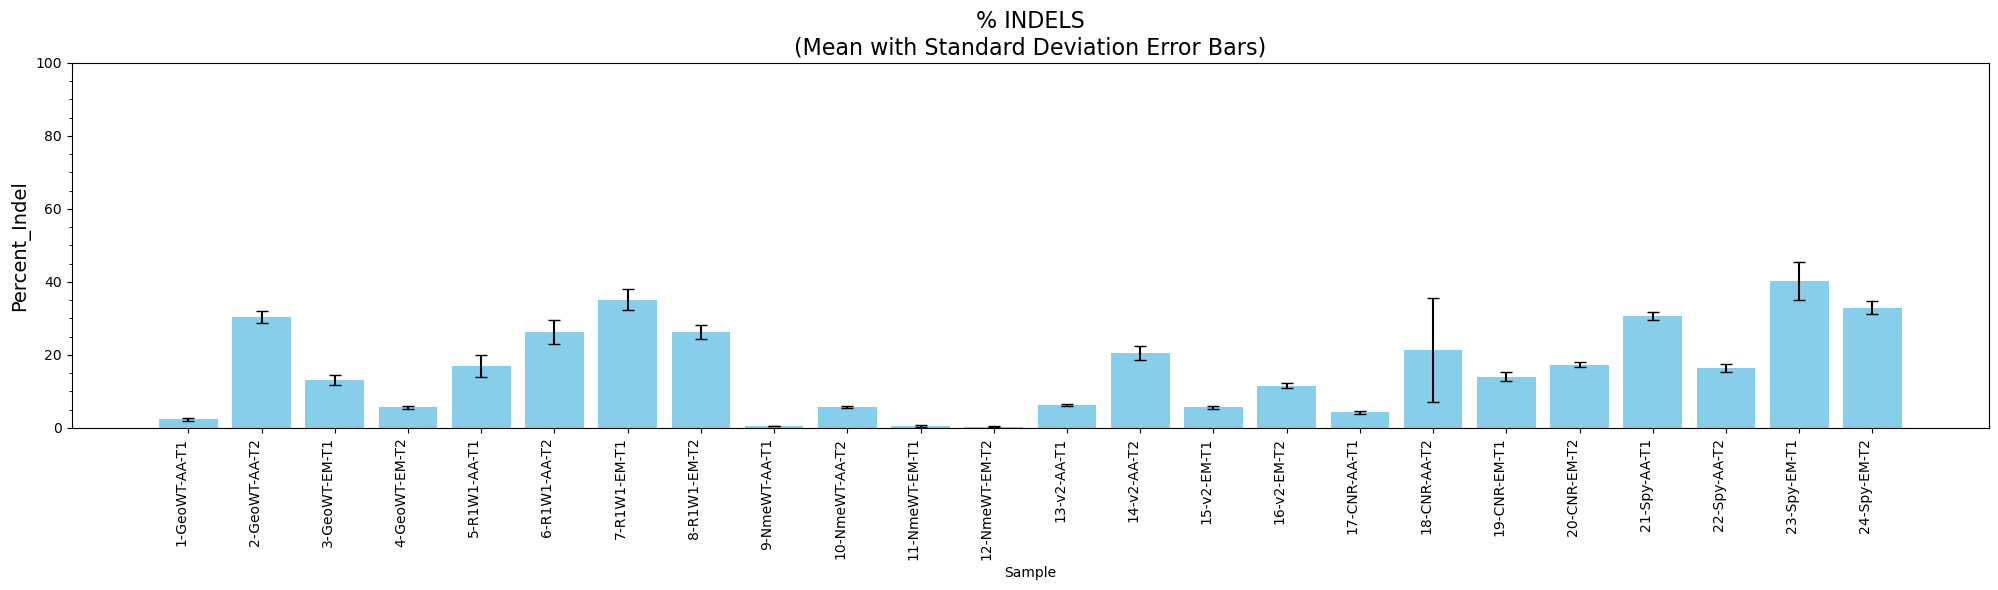

In [5]:
#### PLOT AGG STATS FOR INDELS: Mean and Stdev Error Bars ####
## AGGREGATE REP's
summary_stats = run_summary.groupby('Feature_Type')['Percent_Indel'].agg(['mean', 'std']).reset_index()
summary_stats.sort_values(by='Feature_Type', key=lambda x: x.str.split("-").str[0].astype(int), inplace=True)

## PLOT
fig, ax = plt.subplots(figsize=(20, 6))  # You can adjust the figure size as needed

# BAR CHART
ax.bar(summary_stats['Feature_Type'], summary_stats['mean'], yerr=summary_stats['std'], capsize=4, color='skyblue')

# FORMAT AXIS LABELS AND TITLES
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Percent_Indel', fontsize=14)
ax.set_title('% INDELS\n(Mean with Standard Deviation Error Bars)', fontsize=16)

# AXIS TICKS AND ROTATION
plt.xticks(rotation=90, ha='right')
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.tight_layout() 
plt.ylim(0,100)

plt.savefig(f"Percent_Indels_iGeo_Manuscript_Samples_vAll.png")
plt.show()
